In [87]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.metrics import classification_report, accuracy_score, log_loss,average_precision_score,confusion_matrix,ConfusionMatrixDisplay

import plotly.express as px
import seaborn as sns

#used for calling models from other notebooks
from joblib import load

In [88]:
#final_features=pd.read_csv('total_features', sep=',', header=0) 
#final_features=pd.read_csv('total_features', sep=',', header=0) 
final_features = pd.read_csv('/Users/noimotbakare/Dropbox/Erdos_Project_FL2025/Fast_Fraud_Screening/total_features', sep=',', header=0)
total_data = pd.read_csv('/Users/noimotbakare/Dropbox/Fraud_Payments/data/fraud_payment_data', sep=',', header=0)

In [89]:
total_data=total_data[total_data.USD_amount>0]
total_data=total_data.reset_index(drop=True)
total_data


,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498151,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498152,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498153,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [90]:
#confirming the length of both tables before merging
len(final_features), len(total_data)


(1498155, 1498155)

In [91]:
#Sanity check to verify the two dfs are align
(final_features.index == total_data.index).all()

np.True_

In [92]:
#Adding USD to final features because they were not included in the modeling features 
final_features["USD_amount"] = total_data["USD_amount"]

In [93]:
##Split for train, validate and test data
train_features=final_features[0:1000000]
validate_features=final_features[1000000:1250000]
test_features=final_features[1250000:-1]

y_train=total_data['Label'][0:1000000]
y_validate=total_data['Label'][1000000:1250000]
y_test=total_data['Label'][1250000:-1]

##Scaler for eventual Logistic regression
X=StandardScaler().fit_transform(train_features.values)

In [94]:
#Running XGboost to identify threshold  
from xgboost import XGBClassifier
import pandas as pd

# Train model
xgb_model= XGBClassifier(
    max_depth=70,
    learning_rate=0.01,
    n_estimators=700,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10  # fraud imbalance handling
)

xgb_model.fit(train_features, y_train)

# # Use the trained logistic regression model to predict how likely each transaction in X_test is to be fraudulent.
# y_test_xgb_pr = xgb_model.predict_proba(X_test)[:,1]
# Predict probabilities




,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


                                               Business KPIs

In [95]:

#Create DataFrame from X_test
df_test = pd.DataFrame(test_features)

#Fraud 
df_test["is_fraud"] = y_test.values
#modelscore - it's a continous scrore from the model that gives a 0-1 probability 
df_test["model_score"] = xgb_model.predict_proba(test_features)[:, 1]


In [96]:
#model flag 
# Threshold to create model_flag
threshold = 0.5 #the ideal threshold determine in our analysis 
df_test["model_flag"] = (df_test["model_score"] >= threshold).astype(int)

df_test


,bene_prob,Fraud_percentage_bene,Fraud_index_bene,Fraud_centrality_bene,bene_in_deg,bene_out_deg,fraud_rate_by_country_bene,sender_prob,Fraud_percentage_sender,Fraud_index_sender,...,EXCHANGE,MAKE-PAYMENT,MOVE-FUNDS,PAY-CHECK,QUICK-PAYMENT,WITHDRAWAL,USD_amount,is_fraud,model_score,model_flag
1250000,0.728477,0.000000,1.000000e-08,0.000000,12.0,7.0,0.020788,0.821381,0.000000,1.000000e-08,...,0,0,0,1,0,0,744.52,0,0.001142,0
1250001,0.680332,0.000000,1.000000e-08,0.000000,12.0,29.0,0.020788,0.866326,0.000000,1.000000e-08,...,0,0,0,0,0,1,809.74,0,0.035576,0
1250002,0.463966,0.000000,1.000000e-08,0.000000,16.0,27.0,0.020788,0.587769,0.000000,1.000000e-08,...,0,0,0,0,0,1,287.63,0,0.004016,0
1250003,0.787595,0.000000,1.000000e-08,0.000000,9.0,15.0,0.020788,0.705942,0.000000,1.000000e-08,...,0,0,0,0,0,0,526.21,0,0.001449,0
1250004,0.137669,0.076923,1.000000e+00,0.304348,12.0,27.0,0.020788,0.352083,0.076923,1.000000e+00,...,0,0,0,0,0,1,100.46,0,0.016692,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498149,0.599824,0.000000,1.000000e-08,0.000000,30.0,41.0,0.020571,0.785687,0.000000,1.000000e-08,...,0,0,0,0,0,1,505.43,0,0.002248,0
1498150,0.958891,0.000000,1.000000e-08,0.000000,1.0,1.0,0.020571,0.301462,0.000000,1.000000e-08,...,0,1,0,0,0,0,159.64,0,0.001080,0
1498151,0.193204,0.076923,1.000000e+00,0.135135,9.0,4.0,0.020571,0.264044,0.075188,1.000000e+00,...,0,0,0,0,1,0,120.07,0,0.008223,0
1498152,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.020571,0.055998,0.000000,1.000000e-08,...,0,1,0,0,0,0,25.32,0,0.000214,0


In [97]:
#√Synthetic loss or fraud Loss Avoided score
#missed fraud risk score
#√loss avoided accumulates only when we catch fraud
#
df_test["synthetic_loss"] = df_test["USD_amount"] * df_test["is_fraud"]
df_test["missed_risk"] = df_test["synthetic_loss"] * (1- df_test["model_flag"])
df_test["loss_avoided"] = df_test["synthetic_loss"] * df_test["model_flag"]


                                               Synthetic Loss, Missed Risk and Loss Avoided

In [98]:
total_loss = df_test["synthetic_loss"].sum()
missed_risk = df_test["missed_risk"].sum()
loss_avoided = df_test["loss_avoided"].sum()

missed_risk_pct = missed_risk / total_loss
loss_avoided_pct = loss_avoided / total_loss


print("total loss $:", total_loss,
       "loss avoided", loss_avoided,
      "missed risk", missed_risk)

total loss $: 4274138.65 loss avoided 2357370.4200000004 missed risk 1916768.2300000002


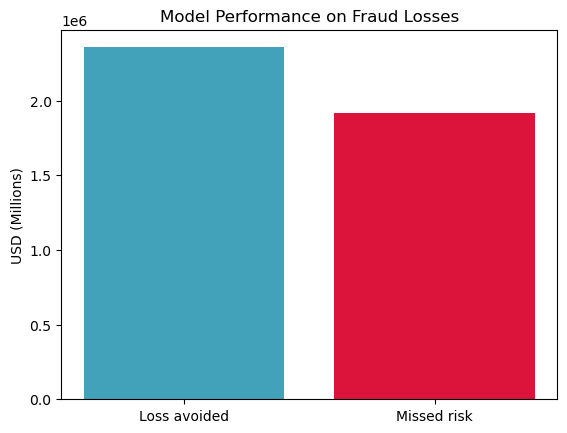

In [99]:
#Vizualizing model performace on Fraud Losses
plt.bar(["Loss avoided", "Missed risk"], [loss_avoided, missed_risk], color=["#42A2B9", "crimson"])
plt.title("Model Performance on Fraud Losses")
plt.ylabel("USD (Millions)")
plt.show()


## Alert Cost Simulation – The Cost of Analysts Reviewing Alerts

Realistically, the estimated cost per analyst ranges from:  
$1–$5 for FinTech firms  
$3–$12 for mid-size banks  
$20–$70 for larger banks  

Since our data is synthetic data from **JPMorgan Chase**, we use the **average cost** from larger banks.  

**Assumption:**  
The average analyst at JPMorgan Chase earns **$50/hour**.  
Given approximately **12 minutes** to review the average case,  
we estimate a **Synthetic Average Review Cost** of:  


$$
\$10 = \left(\frac{\$50}{60\ \text{minutes}}\right) \times 12\ \text{minutes}
$$



In [100]:
synthetic_Avg_review_cost = (50/60) * 12

In [101]:
#review cost 
df_test["review_cost"] = df_test["model_flag"] * synthetic_Avg_review_cost
total_review_cost = df_test["review_cost"].sum()
print("Total review cost $ :", total_review_cost)

Total review cost $ : 20960.0


In [102]:
#Total loss avoided (dollars)
total_loss_avoided = df_test.loc[df_test["loss_avoided"] > 0, "loss_avoided"].sum()

print("Total loss avoided in $:", total_loss_avoided)

Total loss avoided in $: 2357370.42


In [103]:
#Count of positive loss avoided 
fraud_caught = (df_test["loss_avoided"] > 0).sum()
fraud_caught

np.int64(1152)

In [104]:
#Comparing to count of fraud 
total_fraud = (df_test["is_fraud"] == 1).sum()
total_fraud

np.int64(4834)

In [105]:
#rate of fraud caught 
fraud_catch_rate = fraud_caught/total_fraud
fraud_catch_rate

np.float64(0.23831195697145222)

In [106]:
#false positive rate 
#% of legit transactions incorrectly flagged as fraud
fpr = df_test[(df_test.is_fraud==0) & (df_test.model_flag==1)].shape[0] / df_test[df_test.is_fraud==0].shape[0]

#FNR = percentage of fraudulent transactions that model missed
fnr = df_test[(df_test.is_fraud==1) & (df_test.model_flag==0)].shape[0] / df_test[df_test.is_fraud==1].shape[0]

print("False Positive Rate is:", fpr)
print("False Negative Rate is:", fnr)

False Positive Rate is: 0.00387966463915831
False Negative Rate is: 0.7616880430285478
